# Fireveg DB - overview of spatial coverage

Author: [José R. Ferrer-Paris](https://github.com/jrfep) and [Ada Sánchez-Mercado](https://github.com/adasanchez)

Date: 24 August 2024

This Jupyter Notebook includes R code to visualise data from the Fireveg Database. 

The input is loaded from a public data record of the database.

We use this code to create a ...

## Set-up

### Load packages

Packages for plots and maps

In [1]:
library(dplyr)
library(basemaps)
library(ggplot2)
library(sf)
library(ozmaps)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



Packages for data download

In [2]:
library(osfr)
library(jsonlite)

Automatically registered OSF personal access token



### Paths for inputs and outputs

Locate the root directory of the repo

In [3]:
here::i_am("Notebooks/Overview-spatial-coverage.ipynb")

here() starts at /Users/z3529065/proyectos/fireveg/fireveg-analysis



Relative path to local data files within project repository

In [4]:
data_dir <- here::here("data")
if (!dir.exists(data_dir))
    dir.create(data_dir)

### Download data from OSF

<div class="alert alert-info">
     <img src='../img/open-data-2.png' width=25 alt="open data icon"/>
Data for this Notebook is available from the following OSF repository:

> Ferrer-Paris, J. R., Keith, D., & Sánchez-Mercado, A. (2024, August 15). Export data records from Fire Ecology Traits for Plants database. Retrieved from [osf.io/h96q2](https://osf.io/h96q2/)
</div>

Here we will download data programmatically from OSF cloud storage to our local data folder. First we will check the metadata for the target file. We use the `osf_ls_files` function from package `osfr` to explore the metadata of the file associated to the OSF component.

In [5]:
osf_project <- osf_retrieve_node("https://osf.io/h96q2")
file_list <- osf_ls_files(osf_project)

In [6]:
select(file_list, name, id)

name,id
<chr>,<chr>
fire-history.rds,6452ba9d13904f00b7fc85d2
Quadrat-sample-data.rds,6452bab38ea16b0093b69427
site-visits.rds,6452bac07177850087b0f73c
Summary-traits-family.rds,6452bacfb30b4900b4b9ddc4
Summary-traits-species.rds,6452bae3717785008bb0f4b1
field-sites.gpkg,648a583bbee36d028d0e6261
Summary-traits-sources.rds,64966f6fa2a2f4075a436743
Trait-info.rds,649a64e8a2a2f40aa7436407
References-traits-sources.rds,66c8198039554f1e062d2f46


Which files to download from the cloud storage?

In [7]:
files_to_download <- c("field-sites.gpkg")

In [8]:
selected_files <- filter(file_list, name %in% files_to_download)

To download the latest version we apply the `osf_download` function with option `conflicts="overwrite"`. 
If we already have the latest version we can choose option `conflicts="skip"`.

In [9]:
downloaded_files <- osf_download(selected_files,
             data_dir,
             conflicts = "overwrite")


**What about older versions?**

We can request more complete version information with a direct call to the API using the `read_json` function. For example the version for the first downloaded file are available here:

In [10]:
file_versions <- read_json(downloaded_files$meta[[1]]$relationships$versions$links$related$href)

And we could use these urls to download specific versions:

In [11]:
results <- lapply(file_versions$data, function(x) {
    sprintf("version id %s from %s available at %s\n",
            x$id,
            x$attributes$date_created,
            x$links$download)
})
for (res in results) 
    cat(res)

version id 9 from 2024-08-23T09:56:38.343801 available at https://osf.io/download/648a583bbee36d028d0e6261/?revision=9
version id 8 from 2024-08-23T05:08:09.572592 available at https://osf.io/download/648a583bbee36d028d0e6261/?revision=8
version id 7 from 2024-08-23T04:45:11.703464 available at https://osf.io/download/648a583bbee36d028d0e6261/?revision=7
version id 6 from 2024-08-22T12:27:16.037580 available at https://osf.io/download/648a583bbee36d028d0e6261/?revision=6
version id 5 from 2024-08-14T23:20:01.312229 available at https://osf.io/download/648a583bbee36d028d0e6261/?revision=5
version id 4 from 2024-08-14T21:44:45.732352 available at https://osf.io/download/648a583bbee36d028d0e6261/?revision=4
version id 3 from 2023-06-16T08:09:15.536092 available at https://osf.io/download/648a583bbee36d028d0e6261/?revision=3
version id 2 from 2023-06-16T07:58:50.774698 available at https://osf.io/download/648a583bbee36d028d0e6261/?revision=2
version id 1 from 2023-06-15T00:15:55.172533 ava

### Read data from local folder

The data is now available in our local data folder and we can use `readRDS` to read this file into our R session:

In [12]:
site_locs <- read_sf(here::here(data_dir,"field-sites.gpkg"))

## Map of field surveys in NSW 

In [13]:
# use pseudomercator projection 3857
nsw <- st_transform(ozmaps::ozmap_states, 3857) %>% filter(NAME == "New South Wales")
okabe <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

new_surveys <- site_locs |> filter(!survey_name %in% c("TO BE CLASSIFIED", "Mallee Woodlands")) |> st_drop_geometry() 
old_surveys <- site_locs |> filter(survey_name %in% c( "Mallee Woodlands")) |> st_drop_geometry() 

Between October 2019 and December 2021, a total of `r nrow(new_surveys)` field sites were visited at least once in eastern New South Wales (@tbl-datainputs). We also adapted data from `r nrow(old_surveys)` field sites in semi-arid mallee woodlands in southwestern New South Wales surveyed between 2007 and 2018 after experimental fire treatments [@Keith_Tozer_2012 and unpublished data; @tbl-datainputs]. 

### Read API Key for basemaps

In [14]:
readRenviron(here::here("secrets","Renviron.local"))

In [15]:
excluded <- c( "TO BE CLASSIFIED")

field_surveys <- site_locs %>% 
  filter(!survey_name %in% excluded) %>%
  st_transform(3857)


In [16]:

survey_cts <- field_surveys %>% 
  mutate(survey_description = str_replace_all(survey_description, "RF", "Rainforests")  %>%
  str_replace_all("NP", "National Park") %>%
  str_replace_all("NE NSW & SE Qld", "North Eastern NSW")
    ) %>%
  group_by(survey_name,survey_description) %>% 
  summarise(
    nsites=n(),
    min_elev=min(elevation,na.rm=T),
    max_elev=max(elevation,na.rm=T),
    geom=st_union(geom),.groups='keep') %>% 
  st_centroid 

Warning message:
“There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `min_elev = min(elevation, na.rm = T)`.
ℹ In group 3: `survey_name = "Mallee Woodlands"` and `survey_description =
  "Mallee Woodlands"`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [17]:


xys <- st_coordinates(survey_cts) %>% data.frame()
xys$survey_name <- survey_cts$survey_name
xys$survey_desc <- survey_cts %>% 
  transmute(
    description=sprintf("%s (%s sites, %s – %s m)",
      survey_description, nsites, min(pretty(min_elev)), max(pretty(max_elev))
    )) %>%
  pull(description)


Warning message:
“There were 2 warnings in `stopifnot()`.
The first warning was:
ℹ In argument: `description = sprintf(...)`.
ℹ In group 3: `survey_name = "Mallee Woodlands"` and `survey_description =
  "Mallee Woodlands"`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [18]:
st_bbox(st_buffer(nsw,50000))

    xmin     ymin     xmax     ymax 
15645966 -4559732 17151997 -3218793 

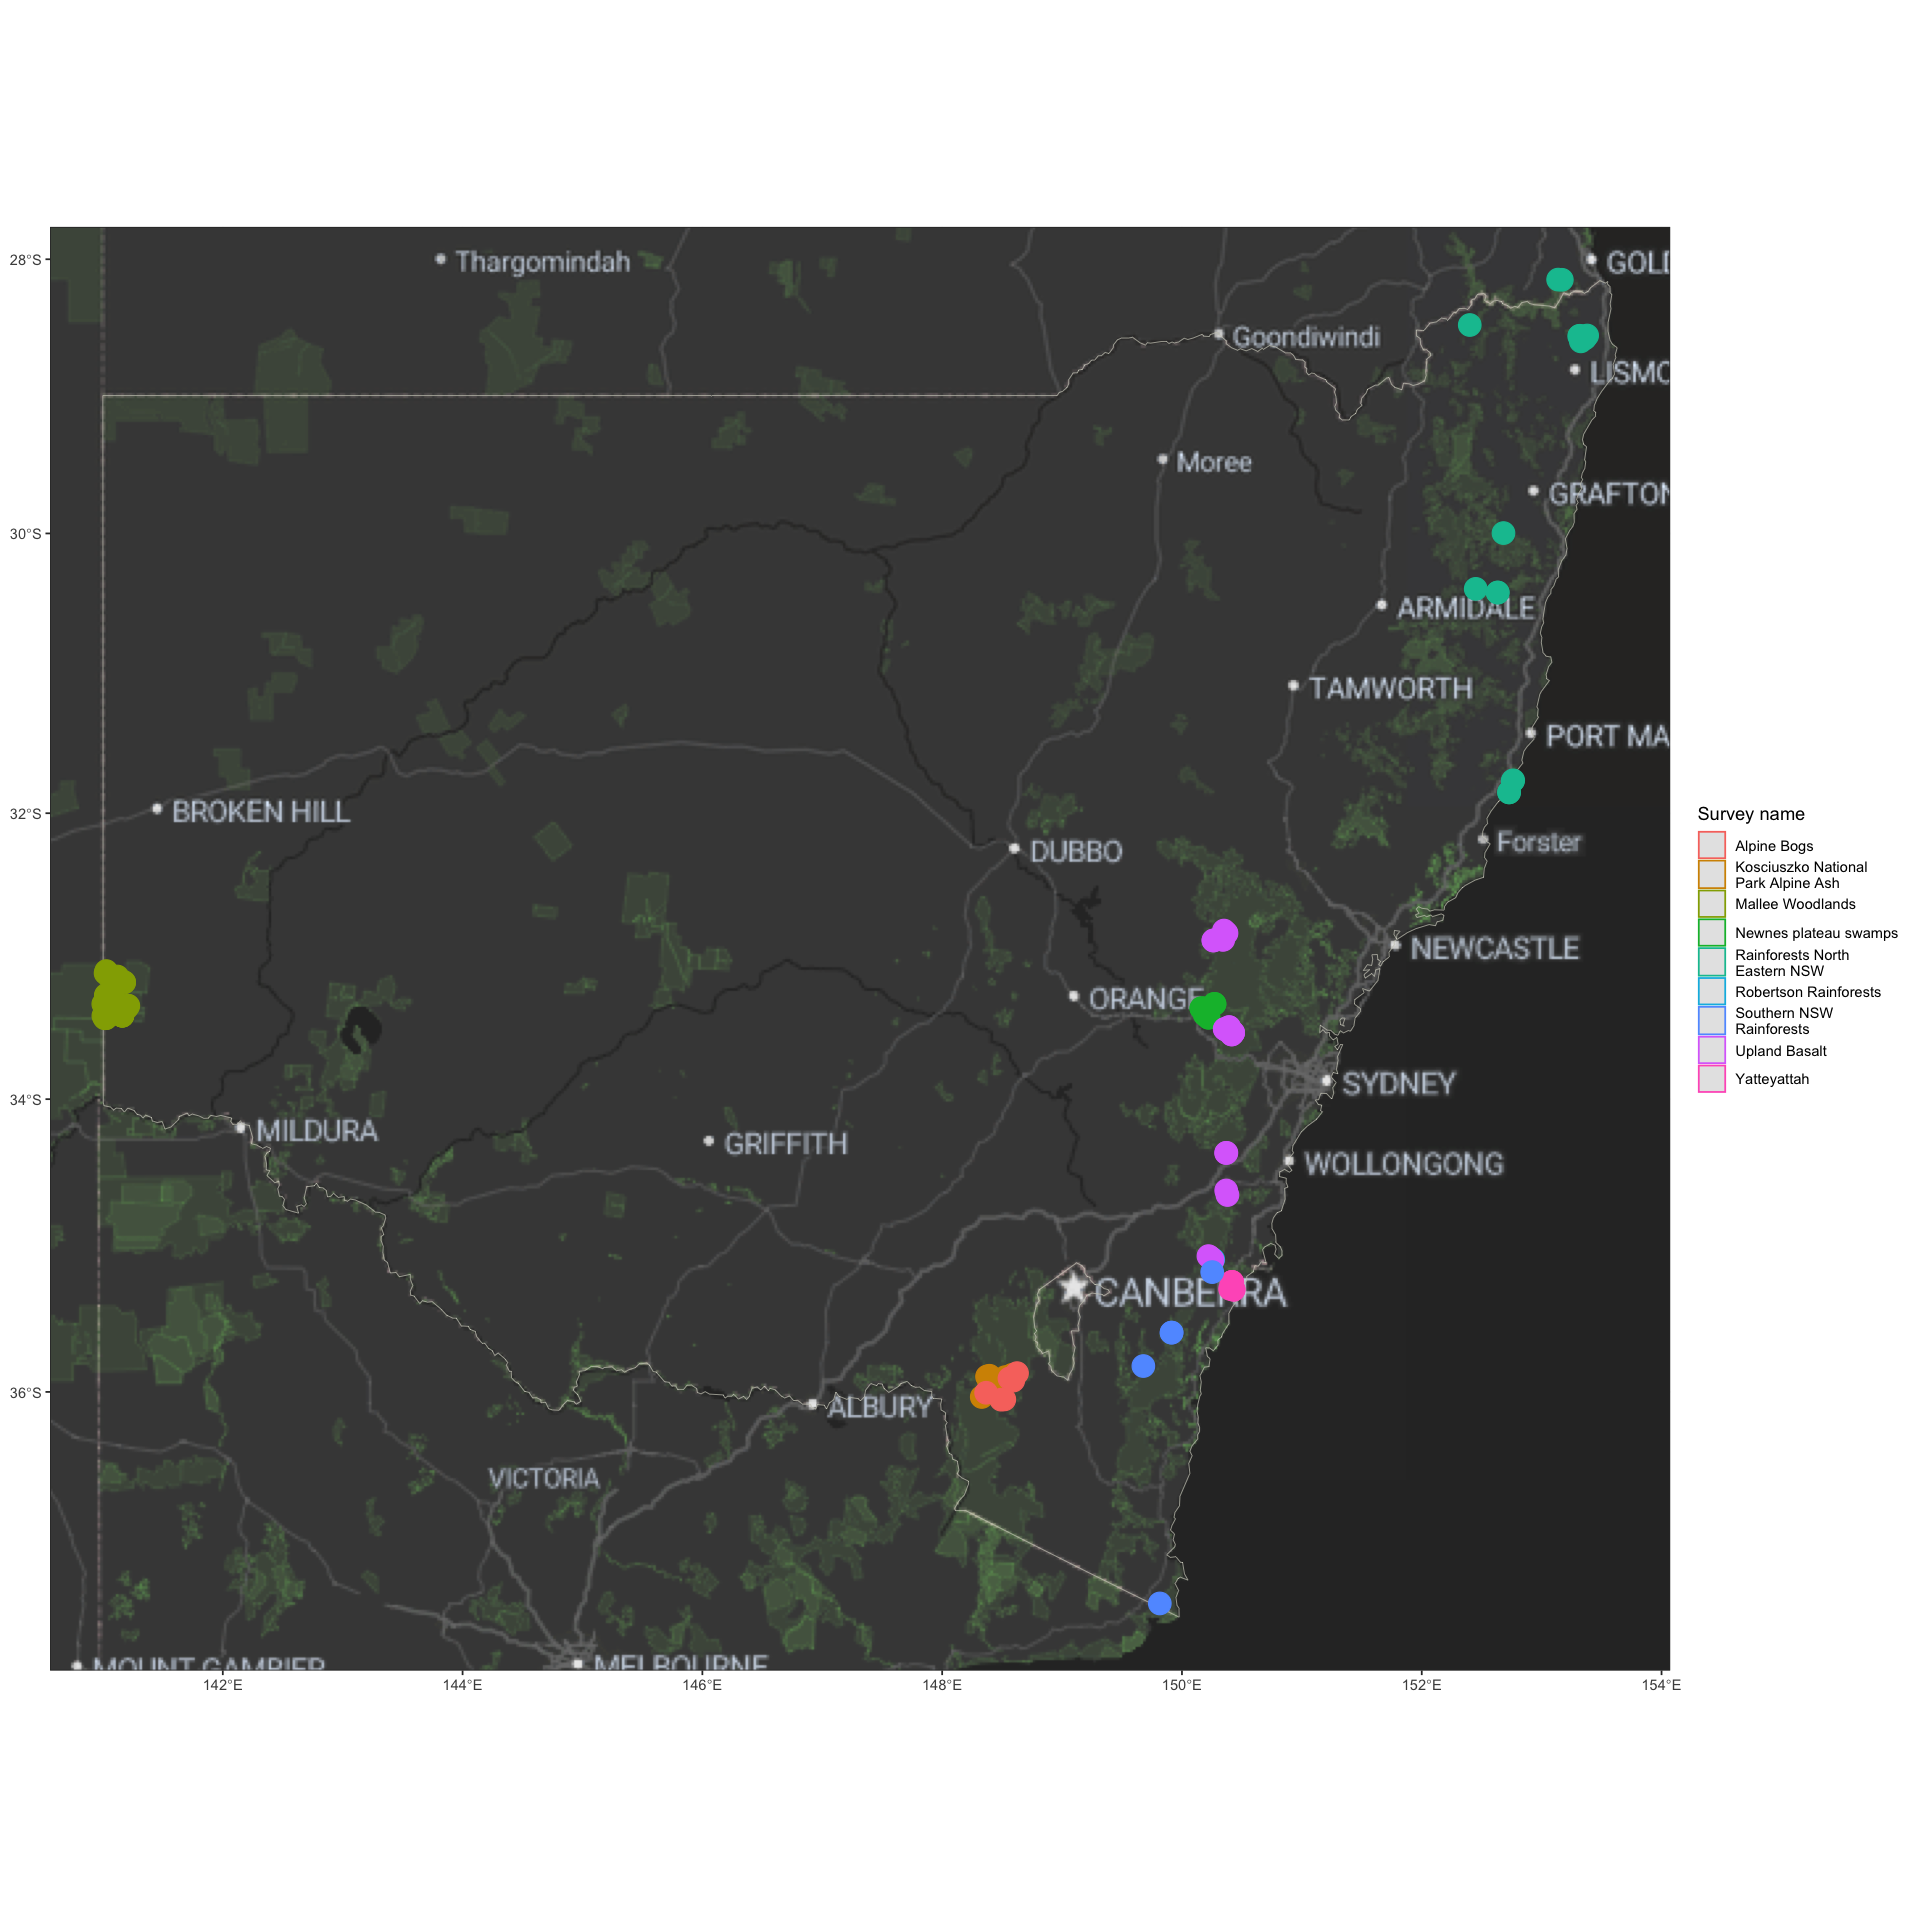

In [19]:
options(repr.plot.width=16,repr.plot.height=16) # Make plot larger
ggplot() + 
        basemap_gglayer(st_bbox(st_buffer(nsw,50000)),
          map_dir = data_dir,
          map_service = "osm_stadia", 
          map_type = "alidade_smooth_dark", 
          map_token = Sys.getenv("STADIA_API_KEY"),
          verbose = FALSE) +
        scale_fill_identity() + 
        geom_sf(data = nsw, fill = NA, colour = 'ivory3') +
        geom_sf(data=field_surveys,aes(colour=survey_name), size=6) + 
        #geom_label_repel(data=xys,
        #                 size=2.75,
        #                 nudge_x = 10,
        #                 nudge_y = 1,
                         #direction = "y",
        #                 aes(label=survey_desc
        #                     , colour=survey_name,x=X,y=Y)) +
          scale_colour_discrete(
            labels = str_wrap(survey_cts$survey_description,22),
            #labels = str_wrap(xys$survey_desc, 18),
              guide = guide_legend(
                title = "Survey name",
                byrow = TRUE,
                theme = theme(
                #legend.direction = "horizontal",
                legend.spacing.y = unit(3.0, 'cm'),
                legend.title.position = "top",
                #legend.text.position = "top",
                #legend.text = element_text(hjust = 0.5, vjust = 0.5)
          ))) +
        scale_x_continuous(expand = c(0, 0)) +
        scale_y_continuous(expand = c(0, 0)) +
        theme_bw() +
        theme(legend.position = "right",
              axis.title.x = element_blank(),
              axis.title.y = element_blank()
        )